In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets 
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable

import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import imread
from PIL import Image
%matplotlib inline

import torch
import torch.utils.data as data_utils
from torch.autograd import Variable

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Image processing 
# transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=(0.5, 0.5, 0.5), 
#                                      std=(0.5, 0.5, 0.5))])
# # # MNIST dataset
# mnist = datasets.MNIST(root='./data/',
#                        train=True,
#                        transform=transform,
#                        download=True)
# Data loader
# data_loader = torch.utils.data.DataLoader(dataset=mnist,
#                                           batch_size=100, 
#                                           shuffle=True)


In [2]:
with open('./im2latex_train.lst','rb') as file:
    match = file.readlines()
train_match_dict = {e.decode('utf-8').split(' ')[0] + '.png':e.decode('utf-8').split(' ')[1] + '.png' for e in match}

In [3]:
def trim_pad(train_match_dict):
    
    hw_imgs, print_imgs = [], []
    for i,hw in enumerate(list(train_match_dict.keys())):
        
        if i%1000 == 0:
            print ("load ",i," data")
        
        #load matched filenames
        pr = train_match_dict[hw]
        
        try:
            #print
            print_img = imread('data/latex_processed/'+pr)
#             print_img_trim = trim(print_img)
#             print_img_pad = pad_img(max_width, max_height, print_img_trim)
#             print_img_bin = to_bin(print_img_pad,up=1)


            #handwritten
            hw_img = imread('data/handwritten_processed/'+hw)
            print_imgs.append(print_img[:40,:253])
            hw_imgs.append(hw_img[:40,:253])

        except:
            #image size exceed max size
            pass
        
        
        
        
    return hw_imgs, print_imgs

In [4]:
print_imgs, hw_imgs = trim_pad(train_match_dict)

load  0  data
load  1000  data
load  2000  data
load  3000  data
load  4000  data
load  5000  data
load  6000  data
load  7000  data
load  8000  data
load  9000  data
load  10000  data
load  11000  data
load  12000  data
load  13000  data
load  14000  data
load  15000  data
load  16000  data
load  17000  data
load  18000  data
load  19000  data
load  20000  data
load  21000  data
load  22000  data
load  23000  data
load  24000  data
load  25000  data
load  26000  data
load  27000  data
load  28000  data
load  29000  data
load  30000  data
load  31000  data
load  32000  data
load  33000  data
load  34000  data
load  35000  data
load  36000  data
load  37000  data
load  38000  data
load  39000  data
load  40000  data
load  41000  data
load  42000  data
load  43000  data
load  44000  data
load  45000  data
load  46000  data
load  47000  data
load  48000  data
load  49000  data
load  50000  data
load  51000  data
load  52000  data
load  53000  data
load  54000  data
load  55000  data
load 

In [5]:
print_imgs_3d = np.concatenate([arr[np.newaxis] for arr in print_imgs])
print_imgs_3d = np.expand_dims(print_imgs_3d, axis=1)
print_imgs_3d.shape

(80396, 1, 40, 253)

In [6]:
hw_imgs_3d = np.concatenate([arr[np.newaxis] for arr in hw_imgs])
hw_imgs_3d = np.expand_dims(hw_imgs_3d, axis=1)
hw_imgs_3d.shape

(80396, 1, 40, 253)

In [7]:
features = torch.from_numpy(hw_imgs_3d).type(torch.FloatTensor)
targets = torch.from_numpy(print_imgs_3d).type(torch.FloatTensor)

In [8]:
batch_size = 100
train = data_utils.TensorDataset(features, targets)
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

In [11]:
Feature_size = 40 * 253

In [12]:
size_1  = 40
size_2 = 253

In [ ]:
# Discriminator
D = nn.Sequential(
    nn.Linear(Feature_size, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(Feature_size, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, Feature_size),
    nn.Tanh())

if torch.cuda.is_available():
    D.cuda()
    G.cuda()

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

# Start training
for epoch in range(100):
    i = 0
    for hws , images in train_loader:
        i += 1
        # Build mini-batch dataset
        batch_size = images.size(0)
        images = to_var(images.view(batch_size, -1))
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = to_var(torch.ones(batch_size))
        fake_labels = to_var(torch.zeros(batch_size))

        #============= Train the discriminator =============#
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        hw = to_var(hws.view(batch_size, -1))
        #z = to_var(torch.randn(batch_size, 64))
        fake_images = G(hw)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #=============== Train the generator ===============#
        # Compute loss with fake images
#         z = to_var(torch.randn(batch_size, 64))
#         fake_images = G(z)
        hw = to_var(hws.view(batch_size, -1))
        #z = to_var(torch.randn(batch_size, 64))
        fake_images = G(hw)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop + Optimize
        D.zero_grad()
        G.zero_grad()
        g_loss.backward(retain_graph=True)
        g_optimizer.step()
        
        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch, 200, i+1, 600, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, size_1, size_2)
        save_image(denorm(images.data), './data/real_images.png')
    
    # Save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, size_1, size_2)
    save_image(denorm(fake_images.data), './data/fake_images-%d.png' %(epoch+1))

# Save the trained parameters 
torch.save(G.state_dict(), './generator.pkl')
torch.save(D.state_dict(), './discriminator.pkl')

/Users/yutingsun/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [0/200], Step[300/600], d_loss: 0.0020, g_loss: 6.3212, D(x): 1.00, D(G(z)): 0.00
Epoch [0/200], Step[600/600], d_loss: 0.0014, g_loss: 6.8058, D(x): 1.00, D(G(z)): 0.00


/Users/yutingsun/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [1/200], Step[300/600], d_loss: 0.0002, g_loss: 8.7553, D(x): 1.00, D(G(z)): 0.00
Epoch [1/200], Step[600/600], d_loss: 0.0002, g_loss: 8.4607, D(x): 1.00, D(G(z)): 0.00
Epoch [2/200], Step[300/600], d_loss: 0.0001, g_loss: 9.1081, D(x): 1.00, D(G(z)): 0.00
Epoch [2/200], Step[600/600], d_loss: 0.0002, g_loss: 8.5008, D(x): 1.00, D(G(z)): 0.00
Epoch [3/200], Step[300/600], d_loss: 0.0001, g_loss: 9.0091, D(x): 1.00, D(G(z)): 0.00
Epoch [3/200], Step[600/600], d_loss: 0.0001, g_loss: 9.8136, D(x): 1.00, D(G(z)): 0.00
Epoch [4/200], Step[300/600], d_loss: 0.0000, g_loss: 10.2329, D(x): 1.00, D(G(z)): 0.00
Epoch [4/200], Step[600/600], d_loss: 0.0001, g_loss: 9.4158, D(x): 1.00, D(G(z)): 0.00
Epoch [5/200], Step[300/600], d_loss: 0.0000, g_loss: 10.7508, D(x): 1.00, D(G(z)): 0.00
Epoch [5/200], Step[600/600], d_loss: 0.0000, g_loss: 11.8505, D(x): 1.00, D(G(z)): 0.00
Epoch [6/200], Step[300/600], d_loss: 0.0000, g_loss: 11.3672, D(x): 1.00, D(G(z)): 0.00
Epoch [6/200], Step[600/600]

In [25]:
to_var(hw.view(batch_size, -1))

Variable containing:
  255   255   255  ...    255   255   255
  255   255   255  ...    255   255   255
  255   255   255  ...    255   255   255
       ...          ⋱          ...       
  255   255   255  ...    255   255   255
  255   255   255  ...    255   255   255
  255   255   255  ...    255   255   255
[torch.FloatTensor of size 100x10120]

In [26]:
40*253

10120

In [22]:
x = fake_images.data.numpy()[0].reshape(40,253)

##  miscellaneous

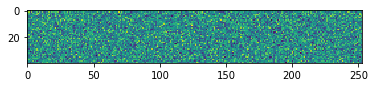

In [23]:
plt.imshow(x)